In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from scipy import stats
from mpl_toolkits import mplot3d
from google.colab import files
import time

Download the csv file and run the block below, hit browse and select the csv file

In [ ]:
uploaded = files.upload()
data = np.genfromtxt('winequalityN.csv', delimiter=',')
#clearing first row 
data_cleaned = np.delete(data,0,0)
#clearing column with wine color
data_cleaned = np.delete(data_cleaned, 0, 1)
#clearing column with wine quality for use later
data_cleaned = np.delete(data_cleaned, 11, 1)
data_cleaned.shape

Saving winequalityN.csv to winequalityN (5).csv


(6497, 11)

In [ ]:
#clearing all rows with nan values
nan_array = np.isnan(data_cleaned)
data_cleaned = data_cleaned[~nan_array.any(axis=1)]
#load cleaned data into pandas dataframe
data_cleaned = pd.DataFrame(data_cleaned)
#remove outliers
data_cleaned = data_cleaned[(np.abs(stats.zscore(data_cleaned)) < 3).all(axis=1)]
#making quality/type arrays for model vis
data_type = np.genfromtxt('winequalityN.csv', delimiter=',', dtype = None, encoding = None, skip_header=1,usecols=(0))
data_quality = np.genfromtxt('winequalityN.csv', delimiter=',', skip_header=1,usecols=(12))
#clearing same rows as above
data_type = data_type[~nan_array.any(axis=1)]
data_quality = data_quality[~nan_array.any(axis=1)]

---

### PCA Analysis

In [ ]:
# Find the mean
mean = np.mean(data_cleaned, axis=0)
print(np.shape(mean))
# Find std
std = np.std(data_cleaned, axis=0)
print(np.shape(std))

# Normalize our data
Z = (data_cleaned - mean)/std
print(np.shape(Z))

(11,)
(11,)
(5975, 11)


In [ ]:
# Find covariance matrix
cov = np.cov(Z.T,bias=False)

In [ ]:
# Find eigenvalues and vectors
# As a note, V is eigenvalues and D is eigenvectors according to the documentation
V, D = np.linalg.eig(cov)

In [ ]:
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = lambd
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.shape(lambd)[0]
    Vsort = np.zeros((M, M))
    print(np.shape(Vsort))
    for i in range(M):
        temp = V[:,index[i]]
        Vsort[:,i] = temp
    return Vsort, Dsort

In [ ]:
# Sort the eigenvalues/vectors
V_sort, D_sort = eigsort(D, V)
D.shape
print(D_sort)

(11, 11)
[3.17040646 2.57128993 1.47038467 1.0194447  0.63451618 0.60942358
 0.51042222 0.40525539 0.35285585 0.23218641 0.02565593]


Text(0, 0.5, 'Eigenvalue')

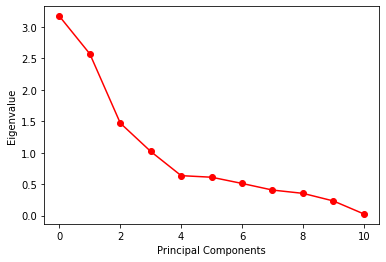

In [ ]:
# Plot the scree plot
plt.plot(range(11), D_sort, 'o-', color='red')
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalue')

[0.28817053139196463,
 0.23371450782614955,
 0.13364896191671813,
 0.0926612798236813,
 0.057673635189278066,
 0.05539287131161952,
 0.04639425416917562,
 0.03683523283808153,
 0.03207243607582293,
 0.021104322804215224,
 0.002331966653293599]

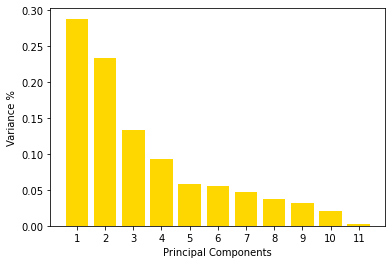

In [ ]:
# Variance percentage of each principal component
variance = []
for i in range(len(D_sort)):
  variance.append(D_sort[i]/np.sum(D_sort))

PC = range(1, len(variance)+1)
plt.bar(PC, variance, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)
variance

In [ ]:
# 80% variability explained by top 5 components
p_0 = Z.dot(V_sort.T[0])
p_1 = Z.dot(V_sort.T[1])
p_2 = Z.dot(V_sort.T[2])
p_3 = Z.dot(V_sort.T[3])
p_4 = Z.dot(V_sort.T[4])
Proj_5 = np.asarray((p_0,p_1,p_2,p_3,p_4))

Proj_5 = Proj_5.T
np.shape(Proj_5)

(5975, 5)

(-4.418916977596534, 5.681495007537601, -5.098929713440658, 4.862327669494449)

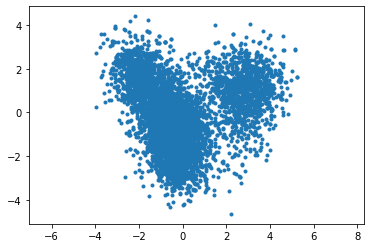

In [ ]:
# Plot the first two principal components (mainly for visualization)
post_pca = pd.DataFrame(Proj_5)
plt.scatter(post_pca[0], post_pca[1], marker='.')
plt.axis('equal')

---

### K-Means clustering on the reduced data

In [ ]:
# Scatterplots the clusters for visualization
def plotCurrent(X, Rnk, Kmus):

    N, D = X.shape
    K = Kmus.shape[0]

    InitColorMat = np.array([[1, 0, 0],
                             [0, 1, 0],
                             [0, 0, 1],
                             [0, 0, 0],
                             [1, 1, 0],
                             [1, 0, 1],
                             [0, 1, 1]])

    KColorMat = InitColorMat[0:K,:]
    print(np.shape(Rnk))

    colorVec = np.dot(Rnk, KColorMat)
    muColorVec = np.dot(np.eye(K), KColorMat)

    # Plots every combination of the principal components
    fig, axs = plt.subplots(5, 2,figsize=(30,50))
    axs[0, 0].scatter(X[:,0], X[:,1], c=colorVec)
    axs[0, 0].set_title('PC2 vs. PC1')
    axs[1, 0].scatter(X[:,0], X[:,2], c=colorVec)
    axs[1, 0].set_title('PC3 vs. PC1')
    axs[2, 0].scatter(X[:,0], X[:,3], c=colorVec)
    axs[2, 0].set_title('PC4 vs. PC1')
    axs[3, 0].scatter(X[:,0], X[:,4], c=colorVec)
    axs[3, 0].set_title('PC5 vs. PC1')
    axs[4, 0].scatter(X[:,1], X[:,2], c=colorVec)
    axs[4, 0].set_title('PC3 vs. PC2')
    axs[0, 1].scatter(X[:,1], X[:,3], c=colorVec)
    axs[0, 1].set_title('PC4 vs. PC2')
    axs[1, 1].scatter(X[:,1], X[:,4], c=colorVec)
    axs[1, 1].set_title('PC5 vs. PC2')
    axs[2, 1].scatter(X[:,2], X[:,3], c=colorVec)
    axs[2, 1].set_title('PC4 vs. PC3')
    axs[3, 1].scatter(X[:,2], X[:,4], c=colorVec)
    axs[3, 1].set_title('PC5 vs. PC3')
    axs[4, 1].scatter(X[:,3], X[:,4], c=colorVec)
    axs[4, 1].set_title('PC5 vs. PC4')

    fig = plt.figure()

    # 3d scatterplot with 3 first components (3 highest variability principal components)
    plt3d = plt.axes(projection = '3d')
    plt3d.scatter(X[:,0], X[:,1], X[:,2], c=colorVec)
    plt3d.scatter(Kmus[:,0], Kmus[:,1], Kmus[:,2], s=200, c=muColorVec)
    plt.show()
        
def calcSqDistances(X, Kmus):
    return ((-2 * X.dot(Kmus.T) + np.sum(np.multiply(Kmus, Kmus), axis=1).T).T + np.sum(np.multiply(X, X), axis=1)).T

def determineRnk(sqDmat):
    m = np.argmin(sqDmat, axis=1)
    return np.eye(sqDmat.shape[1])[m]

def recalcMus(X, Rnk):
    num = X.T.dot(Rnk)
    denom = np.sum(Rnk, axis=0)

    return np.divide(num, denom).T

def runKMeans(K, dataset):
    #load data file specified by fileString from Bishop book
    X = dataset

    #determine and store data set information
    N, D = X.shape

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)

        #check to see if the cluster centers have converged.  If so, break.
        if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
            print(str(iter) + " iterations")
            break

    plotCurrent(X, Rnk, Kmus)
    time.sleep(1)
    return Kmus, Rnk


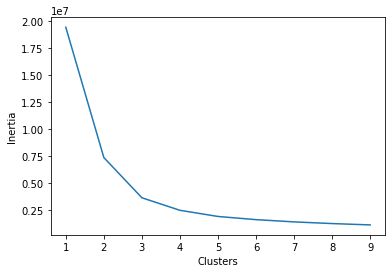

In [ ]:
# Number of clusters to use
inertia=[] 

for i in range(1, 10):
    variance=0
    kmeans=KMeans(n_clusters=i).fit(data_cleaned)
    inertia.append(kmeans.inertia_)
        
plt.plot(range(1,10),inertia)
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.xticks(range(1,10))
plt.show()

# Based on the graph, it seems that 3 clusters are appropriate based on the "elbow method"

14 iterations
(5975, 3)


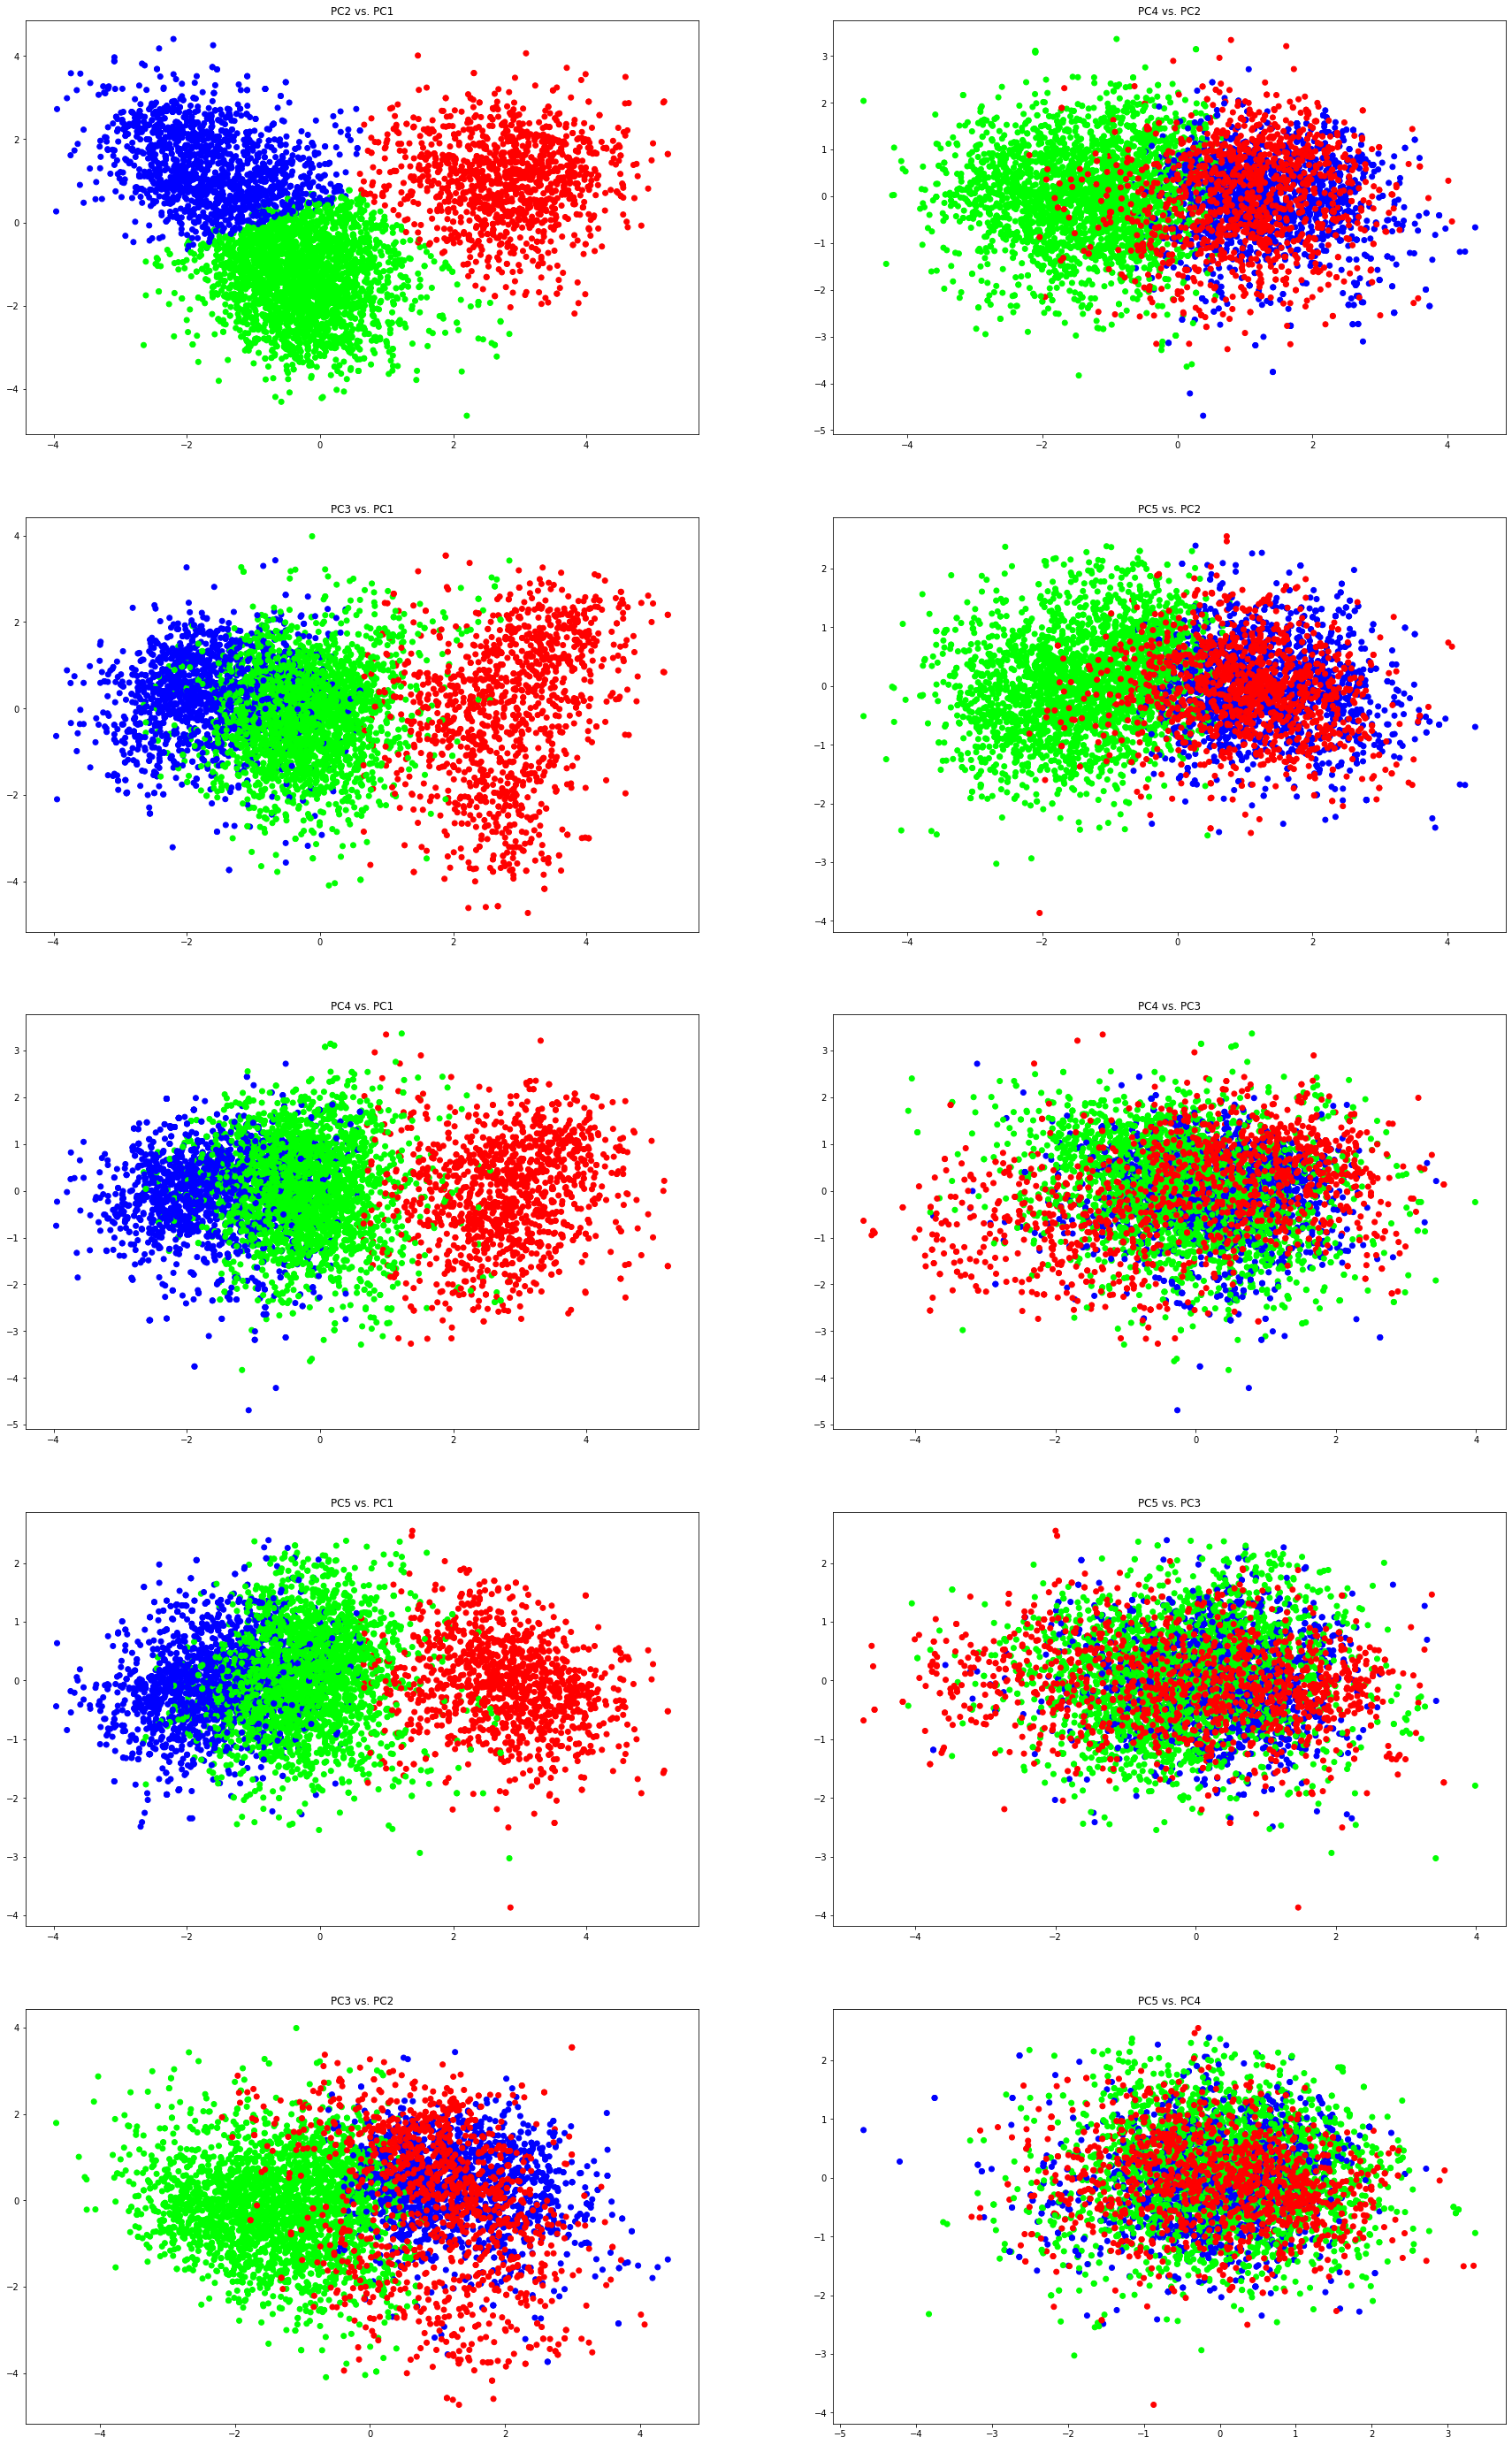

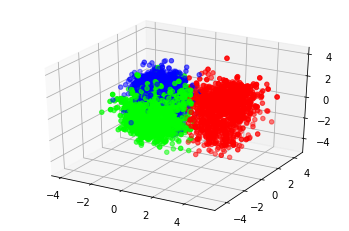

In [ ]:
# Run the k-means algorithm with 3 clusters and our reduced data
Kmus, Rnk = runKMeans(3, Proj_5)

0.5750069735006974
0.5453277545327755
0.5358437935843794
0.5355090655509066
0.5854951185495119
0.5561506276150627
0.5564853556485355
(5975, 3)


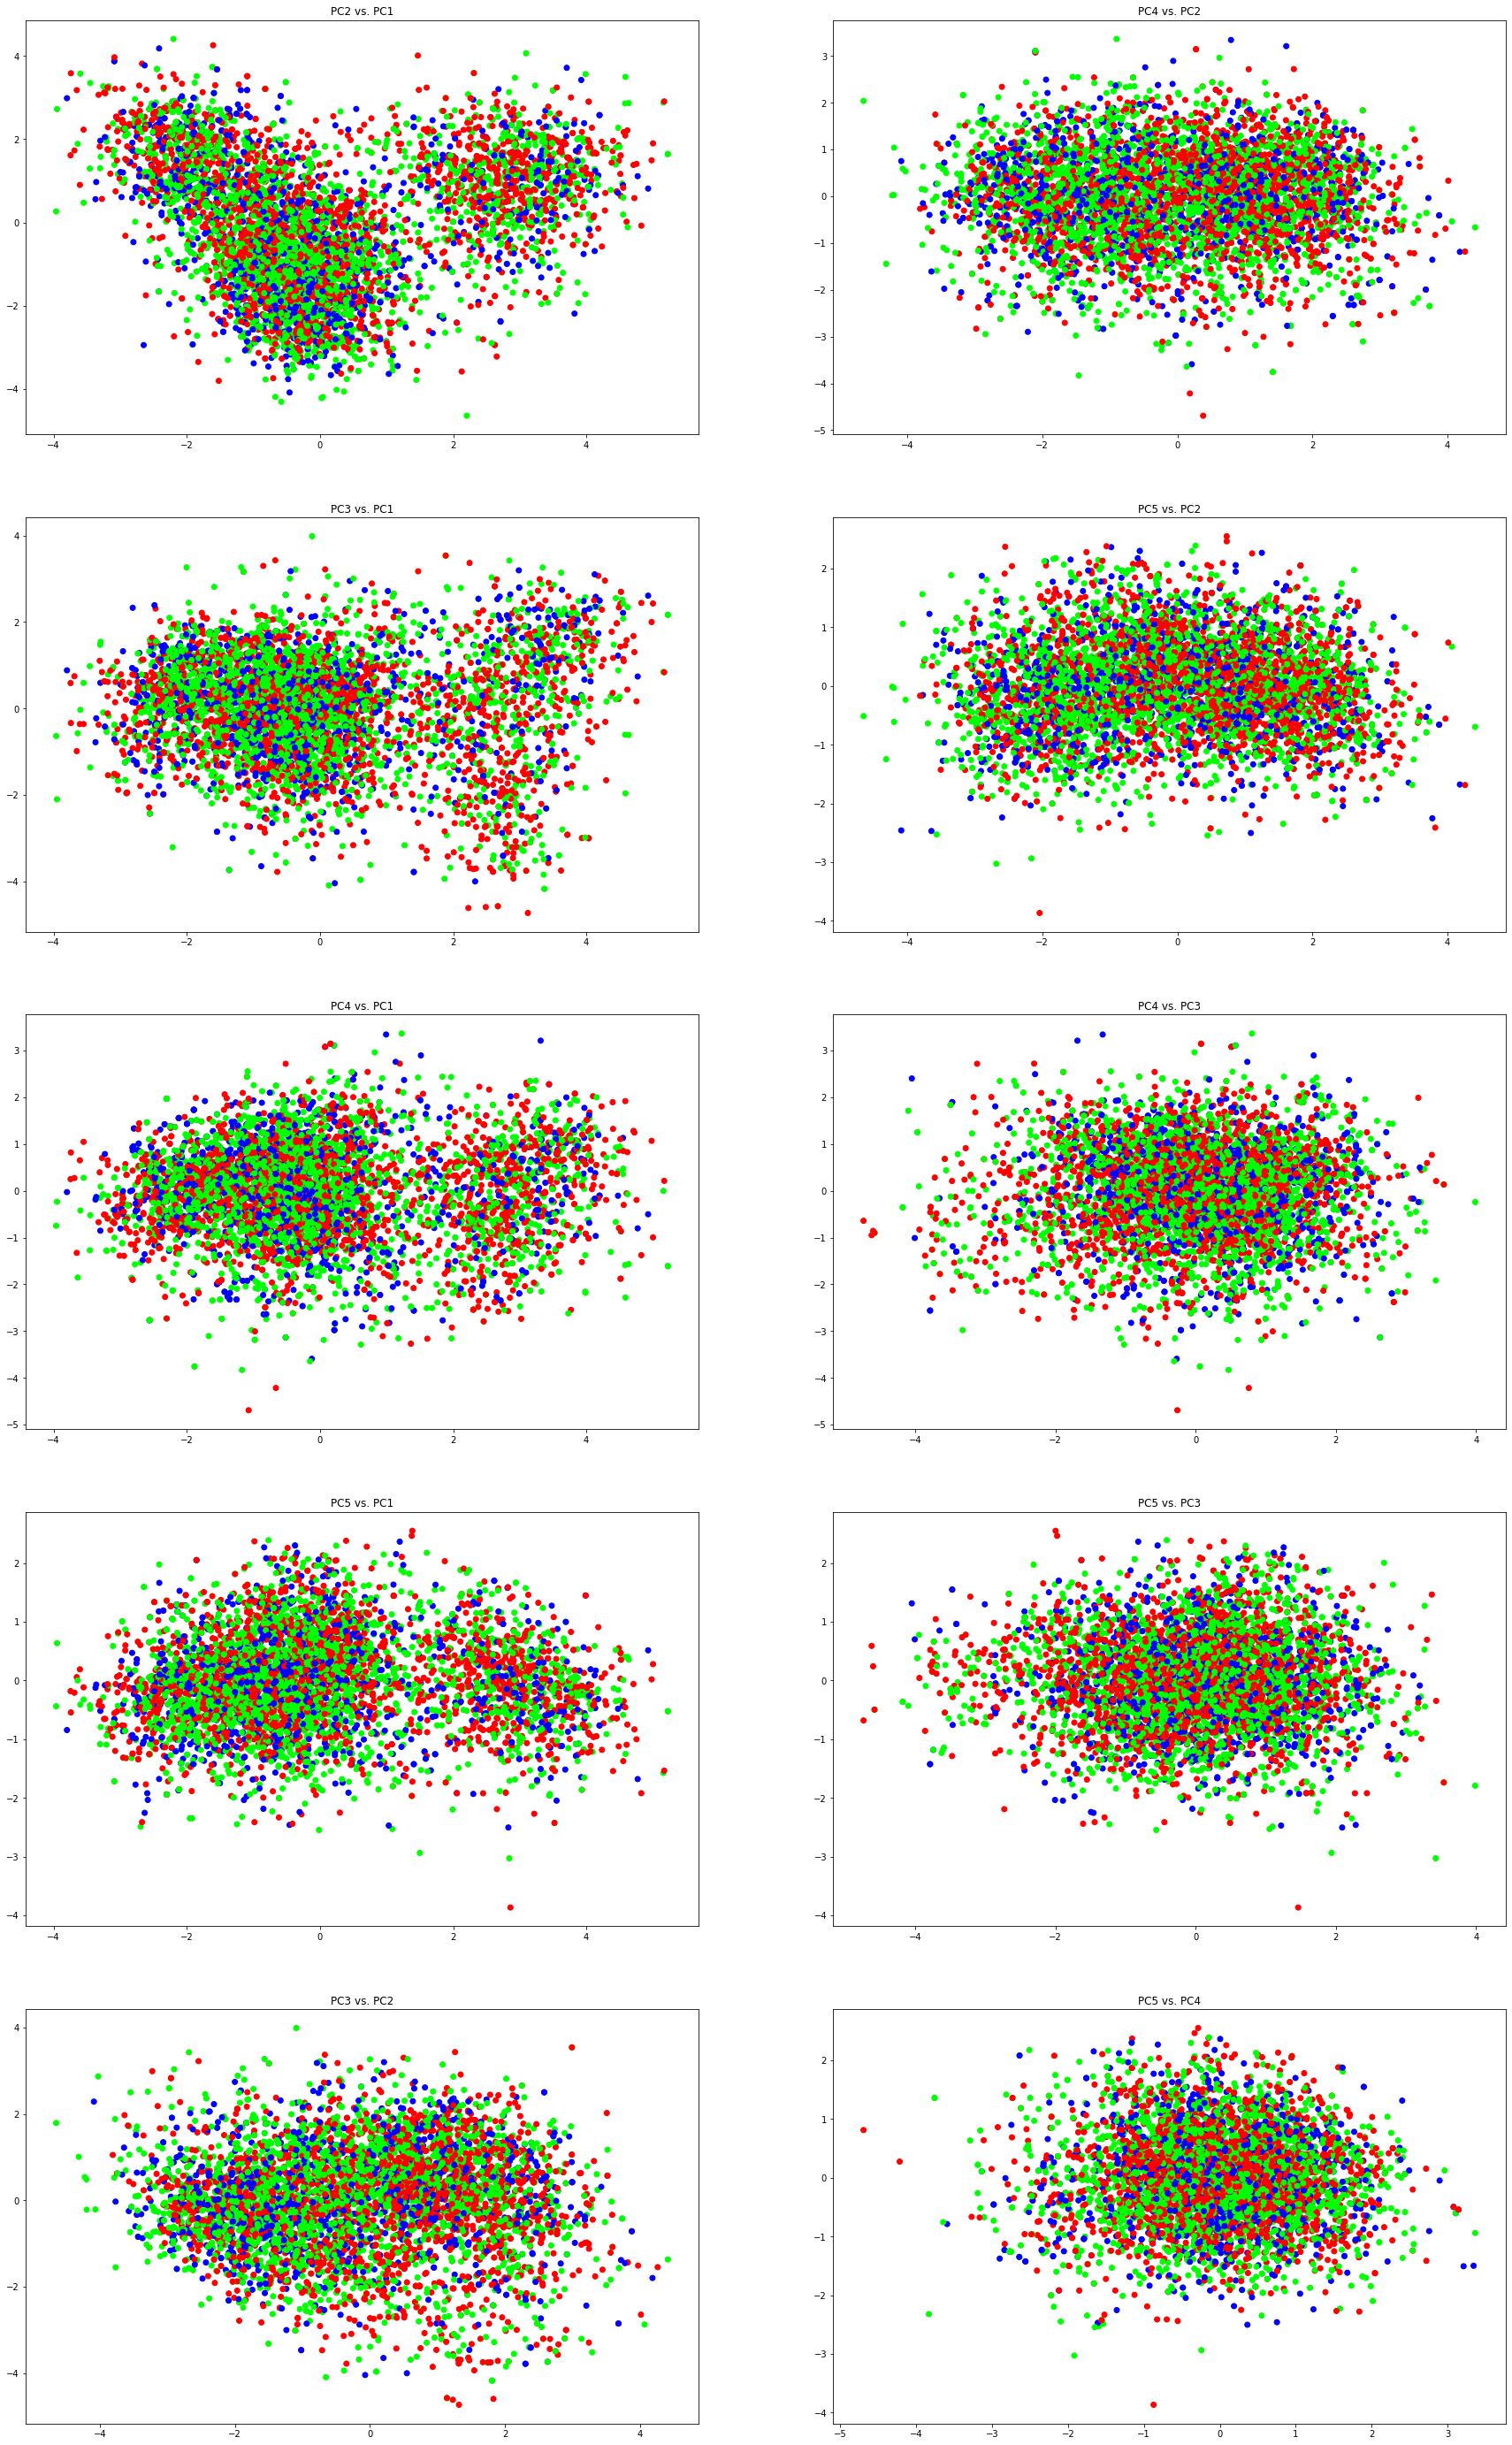

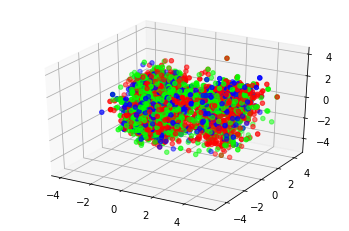

In [ ]:
import random
quality_setHML = np.zeros((5975,3))
quality_setHLM = np.zeros((5975,3))
quality_setMHL = np.zeros((5975,3))
quality_setMLH = np.zeros((5975,3))
quality_setLMH = np.zeros((5975,3))
quality_setLHM = np.zeros((5975,3))
rand_set = np.zeros((5975,3))
# analysis of how closely datapoint cluster assignments correspond to quality assignments, in all possible cluster configurations
for i in range(5975):
  rnum = random.randint(0,2)
  if data_quality[i] > 6:
    quality_setHML[i,0] = 1
    quality_setHLM[i,0] = 1
    quality_setMHL[i,1] = 1
    quality_setMLH[i,2] = 1
    quality_setLMH[i,2] = 1
    quality_setLHM[i,1] = 1
  elif data_quality[i] == 6:
    quality_setHML[i,1] = 1
    quality_setHLM[i,2] = 1
    quality_setMHL[i,0] = 1
    quality_setMLH[i,0] = 1
    quality_setLMH[i,1] = 1
    quality_setLHM[i,2] = 1
  else:
    quality_setHML[i,2] = 1
    quality_setHLM[i,1] = 1
    quality_setMHL[i,2] = 1
    quality_setMLH[i,1] = 1
    quality_setLMH[i,0] = 1
    quality_setLHM[i,0] = 1
  rand_set[i,rnum] = 1
# similarity between quality_sets and cluster assignments are within less than .10 of random set
# there is probably some more sophisticated statistical analyses we could do here :/ don't really want to do that right now though
score1 = np.mean(Rnk == quality_setHML)
score2 = np.mean(Rnk == quality_setHLM)
score3 = np.mean(Rnk == quality_setMHL)
score4 = np.mean(Rnk == quality_setMLH)
score5 = np.mean(Rnk == quality_setLMH)
score6 = np.mean(Rnk == quality_setLHM)
score_rand = np.mean(Rnk == rand_set)
print(score1)
print(score2)
print(score3)
print(score4)
print(score5)
print(score6)
print(score_rand)
# plotting highest similarity quality_set
plotCurrent(Proj_5,quality_setLMH,Kmus)